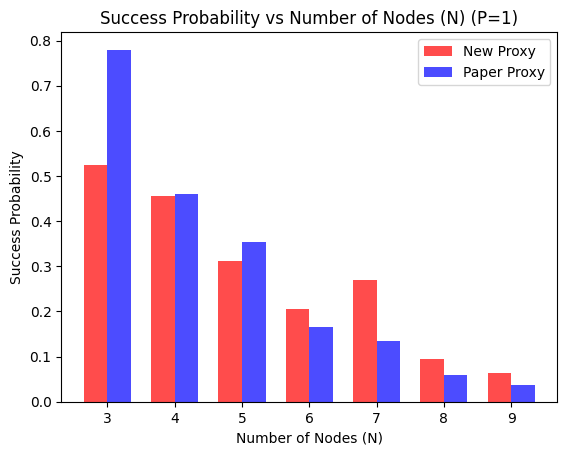

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_overlap, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp

# QAOAの層数
p = 1

# 結果を格納するリスト
success_probs_new_proxy = []
success_probs_paper_proxy = []

# Nを3から10まで変化させて計算
for N in range(3, 10):
    # 各Nについて10回の試行の成功確率を格納するリスト
    success_probs_new_proxy_i = []

    for _ in range(10):
        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaでオーバーラップを計算
        overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

        # 成功確率（オーバーラップ）を計算
        success_prob = overlap

        # 結果をリストに追加
        success_probs_new_proxy_i.append(success_prob)

    # 各Nに対して10回の試行の平均を計算
    success_probs_new_proxy.append(np.mean(success_probs_new_proxy_i))


# Nを3から10まで変化させて計算
for N in range(3, 10):
    # 各Nについて10回の試行の成功確率を格納するリスト
    success_probs_paper_proxy_i = []

    for _ in range(10):
        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result_paper = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result_paper["gamma"]
        beta = result_paper["beta"]

        # 得られたgammaとbetaでオーバーラップを計算
        overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

        # 成功確率（オーバーラップ）を計算
        success_prob = overlap

        # 結果をリストに追加
        success_probs_paper_proxy_i.append(success_prob)

    # 各Nに対して10回の試行の平均を計算
    success_probs_paper_proxy.append(np.mean(success_probs_paper_proxy_i))


# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 10)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index, success_probs_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width, success_probs_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Success Probability')
plt.title(f'Success Probability vs Number of Nodes (N) (P={p})')
plt.xticks(index + bar_width / 2, index)  # x軸の目盛りを設定
plt.legend()

# グラフの表示
plt.show()



In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_overlap, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp

# QAOAの層数
p = 5

# 結果を格納するリスト
success_probs_new_proxy = []
success_probs_paper_proxy = []

# Nを5から9まで変化させて計算
for N in range(3, 10):
    # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
    G = nx.erdos_renyi_graph(N, 0.5)

    # グラフからIsingモデルの項を取得
    ising_model = mc.get_maxcut_terms(G)

    # シミュレーターの初期化
    sim = get_simulator(N, ising_model)

    # 初期のgammaとbetaを設定（全て0.1）
    init_gamma, init_beta = np.full((2, p), 0.1)

    # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
    result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
    gamma = result["gamma"]
    beta = result["beta"]

    # 得られたgammaとbetaでオーバーラップを計算
    overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

    # 成功確率（オーバーラップ）を計算
    success_prob = overlap

    # 結果をリストに追加
    success_probs_new_proxy.append(success_prob)

for N in range(3, 10):
    # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
    G = nx.erdos_renyi_graph(N, 0.5)

    # グラフからIsingモデルの項を取得
    ising_model = mc.get_maxcut_terms(G)

    # シミュレーターの初期化
    sim = get_simulator(N, ising_model)

    # 初期のgammaとbetaを設定（全て0.1）
    init_gamma, init_beta = np.full((2, p), 0.1)

    # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
    result_paper = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
    gamma = result_paper["gamma"]
    beta = result_paper["beta"]

    # 得られたgammaとbetaでオーバーラップを計算
    overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

    # 成功確率（オーバーラップ）を計算
    success_prob = overlap

    # 結果をリストに追加
    success_probs_paper_proxy.append(success_prob)

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 10)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index, success_probs_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width, success_probs_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Success Probability')
plt.title(f'Success Probability vs Number of Nodes (N) (P={p})')
plt.xticks(index + bar_width / 2, index)  # x軸の目盛りを設定
plt.legend()

# グラフの表示
plt.show()

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 